# Final Project

This project models vehicular traffic in two lanes, based on the traffic equation and systems of hyperbolic equations studied in class.

In [1]:
%precision 3
%matplotlib inline

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.optimize import fsolve

# support.py includes code taken directly from the lecture notebooks, such as 
# slope limiters and the ode_rkexplicit function.
%run support.py

## Setup: One-Dimensional Traffic Equation

In the textbook, LeVeque discusses the one-dimensional traffic equation, shown below, which models the movement of vehicular traffic as a wave. 

$$ \rho_t + (\rho u)_x = 0 $$

Here, $\rho(x, t)$ is the density of cars ($0 \leq \rho \leq \rho_M$) and $u(\rho)$ is velocity ($0 \leq u \leq u_M$). Holmes uses the same form, noting some example choices for the velocity function:

* $u(\rho) = a$, constant velocity (advection equation)
* $u(\rho) = u_M \left(1 - \frac{\rho}{\rho_M}\right)$, linear velocity
* $u(\rho) = a \rho \log\left(\frac{\rho_M}{\rho} \right)$, derived from Newell's model

$\rho_M$ is the maximum density, and $u_M$ is the maximum velocity. The linear choice is convenient and straightforward, modelling how traffic tends to slow down as vehicle density increases. This model was used in lecture, where we used $\rho_M = 1$ and $u_M$ = 1. This results in the differential equation

\begin{align*}
&\rho_t + (\rho(1-\rho))_x = 0 &\rho(x, t) \in [0,1]
\end{align*}

With this equation, $\rho=0$ represents an empty road, resulting in free-flowing traffic, while $\rho=1$ represents bumper-to-bumper traffic. There are no source terms in the equations above; this gives us the behavior of a featureless segment of a single travel lane. Modelling entrance and exit ramps would contribute to a source term; in a system of equations for a multilane road, relationships between lanes would result in a source term, as well.

An example solution on $x \in (-1, 1)$ is shown below, with the initial condition

$$\rho(x, 0) = 0.4 + 0.4 \cos\left(\pi x\right)$$

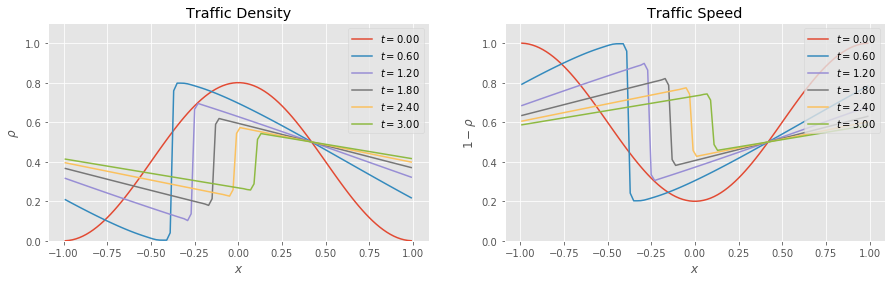

In [2]:
def riemann_traffic(rhoL, rhoR):
    flux_traffic = lambda rho: rho * (1 - rho)
    return numpy.where(rhoL < rhoR,
               numpy.minimum(flux_traffic(rhoL), flux_traffic(rhoR)), # shock
               numpy.where(rhoL < .5,
                   flux_traffic(rhoL),                # rarefaction moving to the right
                   flux_traffic(numpy.maximum(rhoR,   # rarefaction moving to the left
                                             .5))))   # transonic rarefaction

def plot_results(x, hist):
    fig, axes = pyplot.subplots(ncols=2, figsize=(15,4))

    # Plot traffic density on first set of axes
    for t, rho in hist[::len(hist)//5]:
        axes[0].plot(x, rho, label="$t={:.2f}$".format(t))
    axes[0].legend(loc='upper right');
    axes[0].set_xlabel("$x$")
    axes[0].set_ylabel("$\\rho$")
    axes[0].set_ylim(0, 1.1)
    axes[0].set_title("Traffic Density")

    # Plot traffic speed on second set of axes
    for t, rho in hist[::len(hist)//5]:
        axes[1].plot(x, 1 - rho, label="$t={:.2f}$".format(t))
    axes[1].legend(loc='upper right');
    axes[1].set_xlabel("$x$")
    axes[1].set_ylabel("$1 - \\rho$")
    axes[1].set_ylim(0, 1.1)
    axes[1].set_title("Traffic Speed")
    
# Approximate a solution to the traffic equation and begin a plot
traffix_ic = lambda x: 0.4 + 0.4 * numpy.cos(numpy.pi * x)
x, hist = fvsolve2(riemann_traffic, traffix_ic, n=100, limit=limit_sin, tfinal=3)
plot_results(x, hist)

Looking at the higher density peak, we see speeds increase to the right as traffic moves forward. Speeds to the left are initially high with a drop at the congestion, but the differential reduces as traffic advances.

## Traffic in Two Lanes

Munjal and Pipes discuss traffic across multiple lanes travelling in the same direction, using the following system of balance equations.

\begin{align*}
(\rho_1)_t + (f_1)_x = Q_1\\
(\rho_2)_t + (f_2)_x = Q_2
\end{align*}

$\rho_i$ is the density of traffic in lane $i$. $f_i(\rho)$ is the flux in lane $i$, equivalent to $\rho_iu_i$ from the last section. $Q_i$ is the net traffic flow per unit distance entering lane $i$ from outside it, which could be affected by an adjacent lane or ramp.

In the case of two lanes with no ramps connecting other roads, using the system above, we have $Q_2 = -Q_1$. Vehicles may only leave their current lane for the other, and no vehicles enter or leave the system. The authors model this movement as

\begin{align*}
Q_1 &= a (K_2 - K_1)\\
K_i &= \rho_i - \rho_{i,eq}
\end{align*}

$K_i$ is referred to as the density perturbation in lane $i$, describing the rifference between the current traffic density $\rho_i$ and the equilibrium density $\rho_{i,eq}$. $a$ is a constant that affects the rate of lane switching. The idea behind $Q_i$ is that vehicles will switch from a crowded lane to a clearer one until both are carrying the same density of traffic. The rate at which vehicles change is linearly proportional to how far off the current densities are from the equilibrium densities.

$\rho_{i,eq}$ is based on integrating over an indeal speed distribution for lane $i$; for this project, I will assume that the ideal distribution of traffic is to have both lanes carrying equal volumes, so $\rho_{1,eq} = \rho_{2,eq} = \rho_{eq}$. $Q_1$ then simplifies:

\begin{align*}
Q_1 &= a \left((\rho_2 - \rho_{eq}) - (\rho_1 - \rho_{eq})\right)\\
&= a (\rho_2 - \rho_1)
\end{align*}

This says that the exchange of vehicles between two lanes is directly proportional to the difference in traffic densities between the lanes. The 'eagerness' of drivers to change lanes is controlled by $a$.

Written in matrix form, similar to that used in the lecture notebook for the isentropic gas equations and Euler equations, this system looks like

$$U_t + f(U)_x = Q$$

with these values

\begin{align}
U &= \begin{bmatrix} \rho_1 \\ \rho_2 \end{bmatrix} & 
f(U) &= \begin{bmatrix} \rho_1(1-\rho_1) \\ \rho_2(1-\rho_2) \end{bmatrix} &
Q(U) & = \begin{bmatrix} a(\rho_2-\rho_1) \\ a(\rho_1-\rho_2) \end{bmatrix}
\end{align}

The flux Jacobian for this system is

$$ f'(U) = \begin{bmatrix} 1 - 2\rho_1 & 0 \\ 0 & 1 - 2\rho_2 \end{bmatrix} $$

The eigenvalues of this matrix are $\lambda_1 = 1 - 2\rho_1$ and $\lambda_2 = 1 - 2\rho_2$.

With this, we can set up a modified Riemann solver for the problem, which will use periodic boundary conditions. The code below implements this solver, adapted from the extended HLL solver used for the Euler equations in the lecture notebook.

In [3]:
def source_zero(x, U):
    return 0*U

def fvsolve2systembc(riemann, U0, bc, source=source_zero,
                     a=-1, b=1, n=20, tfinal=3, t_step=None, limit=limit_minmod, args=()):
    h = (b - a)/n
    if t_step is None:
        t_step = h/30
    
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    Ubcshape = (Ushape[0], Ushape[1]+4)
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    
    def rhs(t, U):
        Ubc = numpy.empty(Ubcshape)
        Ubc[:,2:-2] = U.reshape(Ushape)
        bc(Ubc)
        jump = Ubc[:,2:] - Ubc[:,:-2]
        r = numpy.zeros_like(jump)
        numpy.divide(Ubc[:,1:-1] - Ubc[:,:-2], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        flux = riemann(Ubc[:,1:-2] + g[:,:-1] * h/2,
                       Ubc[:,2:-1] - g[:,1:] * h/2, *args)
        return ((flux[:,:-1] - flux[:,1:]) / h
                + source(x, Ubc[:,2:-2])).flatten()
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=t_step, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

class TwoLanesTraffic:
    def __init__(self, a=0.1):
        """
        Initializes the system of equations for two lanes of traffic, with the
        rate of vehicles switcing between lanes controlled by a.
        """
        self.a = a

    def density_1(self, U):
        """
        Returns the traffic density in lane 1 from U.
        """
        return U[0]

    def density_2(self, U):
        """
        Returns the traffic density in lane 2 from U.
        """
        return U[1]
    
    def flux(self, U):
        """
        Returns the flux for the two-lane traffic equations, evaluated at U:
        f(U) = [ p1 (1 - p1) ]
               [ p2 (1 - p2) ]

        Parameters:
          U: a 2xn matrix with the following rows
            0: p1, lane 1 traffic density
            1: p2, lane 2 traffic density

        Returns:
          the flux, f(U)
        """
        flux1 = U[0] * (1 - U[0])
        flux2 = U[1] * (1 - U[1])
            
        return numpy.array([flux1, flux2])

    def riemann_hll(self, UL, UR):
        p1L = UL[0]
        p1R = UR[0]
        
        p2L = UL[1]
        p2R = UR[1]
        
        #sL = numpy.minimum(1 - 2 * p1L, 1 - 2 * p1R)
        #sR = numpy.maximum(1 - 2 * p2L, 1 - 2 * p2R)
        
        sL = 1 - 2 * numpy.max([p1L, p1R, p2L, p2R], axis=0)
        sR = 1 - 2 * numpy.min([p1L, p1R, p2L, p2R], axis=0)


        fL = self.flux(UL)
        fR = self.flux(UR)
        
        return numpy.where(sL > 0, fL,
                numpy.where(sR < 0, fR,
                    (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))
    
    def bc_periodic(self, Ubc):
        """
        Provides periodic boundary conditions for the Riemann solver.
        """
        Ubc[:,:2] = Ubc[:,-4:-2]
        Ubc[:,-2:] = Ubc[:,2:4]

    def source_lane_changes(self, x, U):
        """
        Evaluates the source term for two-lane traffic, representing vehicles 
        moving between the lanes.
        source = [ a (p2 - p1) ]
                 [ a (p1 - p2) ]
        """
        source = 0 * U
        source[0] = self.a * (U[1] - U[0])
        source[1] = - source[0]
    
        return source

    def initial_sin_even(self, x):
        """
        Both lanes: reduced amplitude sine (0.3)
        """
        p1 = 0.5 + 0.3 * numpy.sin(-numpy.pi * x)
        p2 = 0.5 + 0.3 * numpy.sin(-numpy.pi * x)
        return numpy.array([p1, p2])
    
    def initial_sin_uneven(self, x):
        """
        Lane 1: half-amplitude sine
        Lane 2: reduced amplitude sine (0.2), still 0.5 baseline
        """
        p1 = 0.5 + 0.5 * numpy.sin(-numpy.pi * x)
        p2 = 0.5 + 0.2 * numpy.sin(-numpy.pi * x)
        return numpy.array([p1, p2])
    
    def initial_cos_empty(self, x):
        """
        Lane 1: reduced amplitude sine (0.4)
        Lane 2: no traffic
        """
        p1 = 0.4 + 0.4 * numpy.cos(numpy.pi * x)
        p2 = 0 * x
        return numpy.array([p1, p2])

def plot_densities(problem, x, hist, until=None, n=5):
    """
    Plots the density of traffic in two travel lanes in separate plots.
    """
    if until is None:
        laststep = len(hist) - 1
    else:
        laststep = numpy.searchsorted([t for t,U in hist], until)

    densities = [(1, problem.density_1),
                 (2, problem.density_2)]

    fig, axes = pyplot.subplots(ncols=2, figsize=(15,4))
        
    for (lane_num, get_density) in densities:
        axis_idx =  lane_num - 1
        
        for step in numpy.linspace(0, laststep, n, dtype=int):
            t, U = hist[step]
            axes[axis_idx].plot(x, get_density(U), 
                        label='$t={:.3f}$'.format(t))
        axes[axis_idx].set_xlabel("$x$")
        axes[axis_idx].set_ylabel("$\\rho_{:d}$".format(lane_num))
        axes[axis_idx].set_title("Lane {:d} Traffic Density".format(lane_num))
        axes[axis_idx].legend(loc='upper right')
        axes[axis_idx].set_ylim(0, 1.1)

def plot_speeds(problem, x, hist, until=None, n=5):
    """
    Plots the speed of traffic in two travel lanes in separate plots.
    """
    if until is None:
        laststep = len(hist) - 1
    else:
        laststep = numpy.searchsorted([t for t,U in hist], until)

    densities = [(1, problem.density_1),
                 (2, problem.density_2)]

    fig, axes = pyplot.subplots(ncols=2, figsize=(15,4))
    for (lane_num, get_density) in densities:
        axis_idx =  lane_num - 1
        
        for step in numpy.linspace(0, laststep, n, dtype=int):
            t, U = hist[step]
            axes[axis_idx].plot(x, 1 - get_density(U), 
                        label='$t={:.3f}$'.format(t))
        axes[axis_idx].set_xlabel("$x$")
        axes[axis_idx].set_ylabel("$1 - \\rho_{:d}$".format(lane_num))
        axes[axis_idx].set_title("Lane {:d} Traffic Speed".format(lane_num))
        axes[axis_idx].legend(loc='lower right')
        axes[axis_idx].set_ylim(0, 1.1)

# TEST: approximate a solution without source terms (i.e., two fully independent lanes)
# problem = TwoLanesTraffic(a=0.1)
# x, hist = fvsolve2system(problem.riemann_hll, problem.initial_sin_2, n=200, limit=limit_minmod, args=())
# plot_densities(problem, x, hist, until=2)

Here is an example, using the same initial condition in the first lane that we used for the single-lane problem before; the second lane will start with no traffic. Numerically, the initial conditions are

\begin{align*}
\rho_1(x, 0) &= 0.4 + 0.4 \cos\left(\pi x\right)\\
\rho_2(x, 0) &= 0\\
\end{align*}

We'll use $a=0.5$ in the source functions.

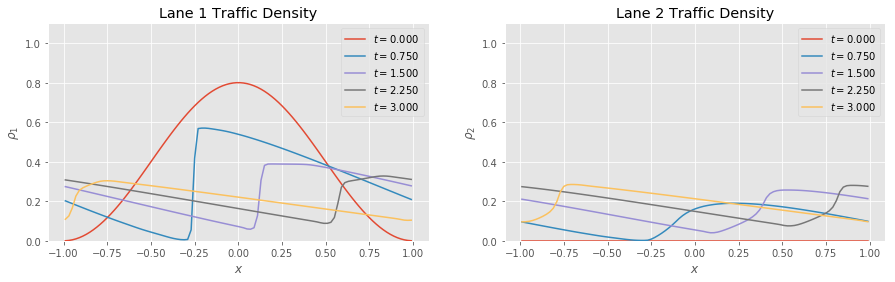

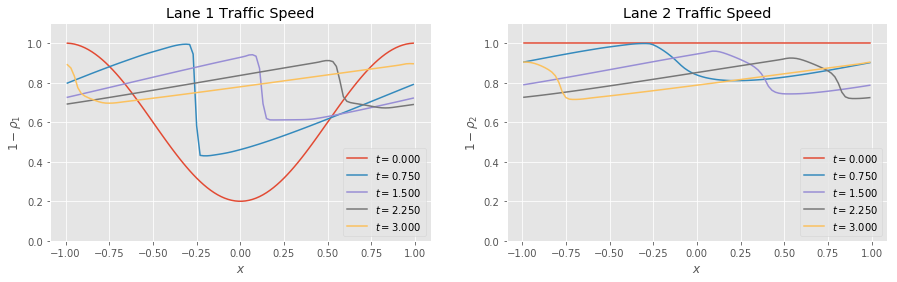

In [ ]:
problem = TwoLanesTraffic(a=0.5)
x, hist = fvsolve2systembc(
                problem.riemann_hll, problem.initial_cos_empty, problem.bc_periodic,
                source=problem.source_lane_changes, n=100, limit=limit_minmod, tfinal=3,
                args=())

plot_densities(problem, x, hist, until=3)
plot_speeds(problem, x, hist, until=3)

Compared to the single lane case, we see traffic density spread out more quickly in lane one, with the speed differential reducing more quickly. Lane two takes on traffic, mostly from the congested section. At $t=3$, the two lanes have nearly balanced their traffic densities and have similar speed profiles.

To observe the effect of $a$ on the exchange of traffic between lanes, here is an example with the same initial conditions, but with $a=0.9$. This represents drivers being more eager to switch to a less congested lane.

In [ ]:
problem = TwoLanesTraffic(a=0.4)
x, hist = fvsolve2systembc(
                problem.riemann_hll, problem.initial_cos_empty, problem.bc_periodic,
                source=problem.source_lane_changes, n=100, limit=limit_minmod, tfinal=3,
                args=())

plot_densities(problem, x, hist, until=3)
plot_speeds(problem, x, hist, until=3)

With this high $a$ value, traffic in the congested section moves quickly from lane one to lane two, and the lanes balance out sooner.

With lower $a$ values, traffic density would transfer to lane two more slowly, so the congestion would dissipate more similarly to the single lane case. With $a=0$, we would have two independent lanes, so lane one would act the same as the single lane case, and lane two would remain empty. (Practically, $a=0$ might represent a physical separation between lanes preventing drivers from switching.) 

## Scenario: Closed Road Reopens

Next, we'll look at a traffic jam scenario in the single and double lane case. First, here is the single lane case, using the following initial condition:

$$ \rho(x, 0) = \left\{\begin{matrix} 1 & x \leq 0\\ 0 & x > 0 \end{matrix}\right\} $$

This represents stopped, packed traffic on the left and an empty road on the right, which might be the case when a road is reopened after a sudden closure.

In [ ]:
traffix_ic_jam = lambda x: 1.0 * (x <= 0)
x, hist = fvsolve2(riemann_traffic, traffix_ic_jam, n=100, limit=limit_sin, tfinal=3)
plot_results(x, hist)

With one lane, traffic begins to advance from the right end of the jam; as the road becomes less congested, traffic further left in the jam begins to move forward. As time goes on, density and speed even out.

Next, we'll look at the two lane case. If both lanes reopened simultaneously, traffic in both lanes would move the same way as in the single lane case, without any lane-changing. To get some interaction between the lanes, we'll use initial conditions where one lane is already in motion; this could represent a time difference between barriers being removed from the two lanes, or a slower response from the lead driver in one lane.

The initial conditions here are:

\begin{align*}
&\rho_1(x, 0) = \left\{\begin{matrix} 1 & x \leq 0\\ 0 & x > 0 \end{matrix}\right\} & \rho_2(x, 0) = 0.5 - 0.5x
\end{align*}

Lane one starts out stopped on the left, as in the single lane example. Lane two emulates the density of the reopened lane after some time has passed. This example will use $a=0.5$.

In [ ]:
def initial_jam_empty(x):
    """
    Lane 1: reduced amplitude sine (0.4)
    Lane 2: no traffic
    """
#     p1 = 0.5 + (0.5 * (x < 0) + 
#          0.5 * numpy.cos(numpy.pi * x) * (x >= 0))
    
    p1 = (1.0 * (x <= 0))
    #p1 = 0 + (1.0 * (x <= 0)) + (0.5 + 0.5 * numpy.cos(10 * numpy.pi * x)) * ((x > 0) & (x <= 0.1))
    #p2 = 0 * x
    
    # simple line
    p2 = -0.5 * x + 0.5
    
    # Earlier
    #p2 = (1.0 * (x <= -0.5) + (0.5 - x) * ((x > -0.5) & (x <= 0.5)))


    # smoothed
#     p2 = 0.2 + (0.2 * (x < 0) + 
#          0.2 * numpy.cos(numpy.pi * x) * (x >= 0))
    
    return numpy.array([p1, p2])

problem = TwoLanesTraffic(a=0.5)
x, hist = fvsolve2systembc(
                problem.riemann_hll, initial_jam_empty, problem.bc_periodic,
                source=problem.source_lane_changes, n=100, limit=limit_minmod, tfinal=3,
                args=())

plot_densities(problem, x, hist, until=3)
plot_speeds(problem, x, hist, until=3)

The general form of lane one's traffic density is similar to that of the single lane case, but we can see traffic from the stopped section of lane one switching to the less dense lane two immediately. Additionally, some traffic from lane two that has moved past the jam transfers to the empty section of lane one on the right.

## Sources

Laval, Jorge A., Carlos F. Daganzo. "Lane-changing in traffic streams." _Transportation Research Part B: Methodological_ 40.3 (2006): 251-264. <br />
http://www.sciencedirect.com/science/article/pii/S019126150500055X

LeVeque, Randall J. _Numerical Methods for Conservation Laws_ Chapter 4. Basel, 1992. <br />
https://pdfs.semanticscholar.org/1470/c6f43c769572c4cfc94ffc9c5710484ff1e5.pdf

Holmes, Mark H. _Introduction to the Foundations of Applied Mathematics_. Vol. 56. Chapter 5. Springer Science & Business Media, 2009. <br />
http://pub.math.leidenuniv.nl/~chirilusbrucknerm/ds_seminar_2016/holmes_Ch5_traffic_flow.pdf

Munjal, P. K., Louis Albert Pipes. "Propagation of on-ramp density perturbations on unidirectional two-and three-lane freeways." _Transportation Research_ 5.4 (1971): 241-255. <br />
https://www.sciencedirect.com/science/article/pii/0041164771900360

Newell, Gordon F. "A simplified theory of kinematic waves in highway traffic, part I: General theory." Transportation Research Part B: Methodological 27.4 (1993): 281-287.<br />
http://www.sciencedirect.com/science/article/pii/019126159390038C

<!-- 
Papers behind Munjal and Pipes's paper.

Oliver, Robert M., and Tenny Lam. "Statistical experiments with a two-lane flow model." No. ORC-65-20. California Univeristy Berkeley Operations Research Center, 1965.<br />
http://www.dtic.mil/dtic/tr/fulltext/u2/622500.pdf

Gazis, Denos C., Robert Herman, and George H. Weiss. "Density oscillations between lanes of a multilane highway." _Operations Research_ 10.5 (1962): 658-667. <br />
http://www.jstor.org/stable/167887
-->